In [1]:
import arviz as az
import matplotlib.pylab as plt
import matplotlib as mpl
mpl.style.use('plotting.mplstyle')
import numpy as np
np.random.seed(18)
import h5py
from scipy.optimize import minimize
from read_O3_LVK_results import *
import sys
sys.path.append('./../code/')
from utilities import massModel

In [2]:
# Load AR results
precomputed_data = h5py.File("./../data/ar_z_summary.hdf","r")
zs = precomputed_data['posterior/zs'][()]
R_zs = precomputed_data['posterior/R_of_zs'][()]
f_zs = precomputed_data['posterior/f_zs'][()]
R_ref = precomputed_data['posterior/R_ref'][()]

# Also extract mass parameters to enable integration over m1 and m2
alphas = precomputed_data['posterior/alpha'][()]
mu_m1s = precomputed_data['posterior/mu_m1'][()]
sig_m1s = precomputed_data['posterior/sig_m1'][()]
log_f_peaks = precomputed_data['posterior/log_f_peak'][()]
mMins = precomputed_data['posterior/mMin'][()]
mMaxs = precomputed_data['posterior/mMax'][()]
log_dmMins = precomputed_data['posterior/log_dmMin'][()]
log_dmMaxs = precomputed_data['posterior/log_dmMax'][()]

## 1. Get a "best-fit" parameteric model reflecting our AR measurement of the differential rate

In [3]:
# First, define a few parametric models that we think will do a good job capturing the above features

def sigmoid(x,x0,dx,r0,r1):
    
    """
    This is a sigmoid function smoothly increasing from r0 to r0+r1 over a lengthscale dx
    
    Parameters
    ----------
    x : Set of x-axis values
    x0 : Central location at which the sigmoid's value rises between r0 and r0+r1
    dx : Lengthscale over which the sigmoid's rise occurs
    r0 : The y-value corresponding to x<<x0
    r1 : The net rise in the sigmoid's value between x>>x0 and x<<0
    """
    
    return r0 + r1/(1.+np.exp(-(x-x0)/dx))
                       
def broken_pl(x,zb,k1,k2,r0):
    
    """
    Broken power-law
    
    Parameters
    ----------
    x : Set of x-axis values
    zb : Break location at which power-law slopes change
    k1 : Power-law index for x<zb
    k2 : Power-law index for x>zb
    r0 : Value of the broken power-law at x=zb
    """
    
    return r0*np.where(x<zb,((1.+x)/(1.+zb))**k1,((1.+x)/(1.+zb))**k2)

# Initial guess of sigmoid parameters
sigmoid_z0 = 0.65
sigmoid_dz = 0.075
sigmoid_r0 = 18
sigmoid_dr = 40

# Initial guess of bpl parameters
bpl_zb = 0.5
bpl_k1 = 0.
bpl_k2 = 8.
bpl_r0 = 18.

# Read out necessary data
# At redshifts above z=0.8 or so, our AR fit begins reverting to the prior, so restrict our fit to z<0.8
zs_to_fit = zs[zs<0.8]
R_z_target = np.median(R_zs,axis=1)[zs<0.8]

# Least squares loss function under the sigmoid model
def ls_sigmoid(params):
    
    # Read tuple of parameters describing redshift evolution
    z0,dz,r0,dr = params
    R_z_model = sigmoid(zs_to_fit,z0,dz,r0,dr)
    
    # Return squared difference between model prediction and target data
    return np.trapz((np.log(R_z_target)-np.log(R_z_model))**2,zs_to_fit)

# Least squares loss function under broken power law model
def ls_bpl(params):
    
    # Read tuple of parameters describing redshift evolution
    zb,k1,k2,r0 = params
    R_z_model = broken_pl(zs_to_fit,zb,k1,k2,r0)
    
    # Return squared difference between model prediction and target data
    return np.trapz((np.log(R_z_target)-np.log(R_z_model))**2,zs_to_fit)

# Fit!
initial_params_sigmoid = (sigmoid_z0,sigmoid_dz,sigmoid_r0,sigmoid_dr)
sigmoid_soln = minimize(ls_sigmoid,initial_params_sigmoid,method='Nelder-Mead',options={'maxiter':1e4})

initial_params_bpl = (bpl_zb,bpl_k1,bpl_k2,bpl_r0)
bpl_soln = minimize(ls_bpl,initial_params_bpl,method='Nelder-Mead',options={'maxiter':1e4})

print(sigmoid_soln)
print(bpl_soln)

 final_simplex: (array([[ 0.64787116,  0.08490505, 19.13292424, 27.01988727],
       [ 0.64787052,  0.08490474, 19.13292823, 27.01980075],
       [ 0.64787106,  0.084905  , 19.13292395, 27.01985954],
       [ 0.64787117,  0.08490493, 19.13292296, 27.01988603],
       [ 0.64787088,  0.0849049 , 19.13291777, 27.0198808 ]]), array([0.00016221, 0.00016221, 0.00016221, 0.00016221, 0.00016221]))
           fun: 0.00016221061593585295
       message: 'Optimization terminated successfully.'
          nfev: 227
           nit: 132
        status: 0
       success: True
             x: array([ 0.64787116,  0.08490505, 19.13292424, 27.01988727])
 final_simplex: (array([[ 0.44148221,  0.25639662,  3.42789288, 20.43033002],
       [ 0.44148476,  0.25640911,  3.42790678, 20.43040199],
       [ 0.44148455,  0.25641401,  3.42788792, 20.43041875],
       [ 0.44148326,  0.25640713,  3.42788481, 20.43041228],
       [ 0.44148162,  0.25638783,  3.42789171, 20.43030401]]), array([0.00022122, 0.00022122, 0.

In [4]:
# Save our fitting results

fitted_sigmoid_z0,fitted_sigmoid_dz,fitted_sigmoid_r0,fitted_sigmoid_dr = sigmoid_soln.x
fitted_bpl_zb,fitted_bpl_k1,fitted_bpl_k2,fitted_bpl_r0 = bpl_soln.x

with open('./../macros/fitting_results_z.txt','w') as macrofile:
    
    macrofile.write("\\newcommand{{\\RedshiftFitSigmoidZCenter}}{{{0:.2f}}}".format(fitted_sigmoid_z0))
    macrofile.write("\n")
    
    macrofile.write("\\newcommand{{\\RedshiftFitSigmoidDeltaZ}}{{{0:.2f}}}".format(fitted_sigmoid_dz))
    macrofile.write("\n")
    
    macrofile.write("\\newcommand{{\\RedshiftFitSigmoidRateLow}}{{{0:.1f}}}".format(fitted_sigmoid_r0))
    macrofile.write("\n")
    
    macrofile.write("\\newcommand{{\\RedshiftFitSigmoidDeltaRate}}{{{0:.1f}}}".format(fitted_sigmoid_dr))
    macrofile.write("\n")
    
    macrofile.write("\\newcommand{{\\RedshiftFitBplZBreak}}{{{0:.2f}}}".format(fitted_bpl_zb))
    macrofile.write("\n")
    
    macrofile.write("\\newcommand{{\\RedshiftFitBplKappaLow}}{{{0:.1f}}}".format(fitted_bpl_k1))
    macrofile.write("\n")
    
    macrofile.write("\\newcommand{{\\RedshiftFitBplKappaHigh}}{{{0:.1f}}}".format(fitted_bpl_k2))
    macrofile.write("\n")
    
    macrofile.write("\\newcommand{{\\RedshiftFitBplRateBreak}}{{{0:.1f}}}".format(fitted_bpl_r0))
    macrofile.write("\n")

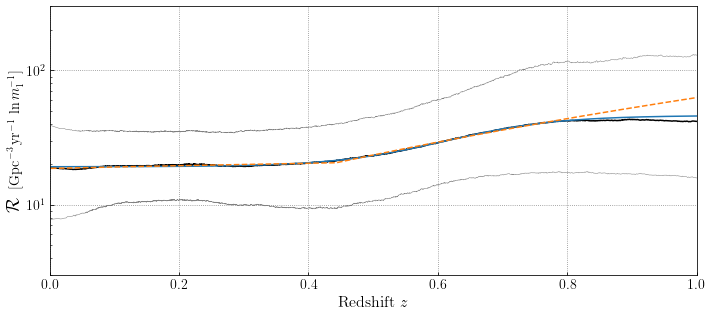

In [5]:
# Finally, plot our fits to double-check that everything is working as intended

# Set up figure
fig = plt.figure(figsize=(10,4.5))
ax = fig.add_subplot(111)
ax.set_rasterization_zorder(2)

# Plot AR model results
ax.plot(zs,np.median(R_zs,axis=1),color='black',zorder=1)
ax.plot(zs,np.quantile(R_zs,0.05,axis=1),color='grey',lw=0.5,zorder=1)
ax.plot(zs,np.quantile(R_zs,0.95,axis=1),color='grey',lw=0.5,zorder=1)

# Plot least-squares sigmoid fit
sigmoid_fit_results = sigmoid(zs,*sigmoid_soln.x)
ax.plot(zs,sigmoid_fit_results)

# ...and least-squares BPL fit
bpl_fit_results = broken_pl(zs,*bpl_soln.x)
ax.plot(zs,bpl_fit_results,ls='--')

# Misc formatting
ax.tick_params(labelsize=14)
ax.set_xlim(0,1.)
ax.set_ylim(0,100)
ax.set_ylim(3,3e2)
ax.set_yscale('log')
ax.set_ylabel(r'$\mathcal{R}$ \,{\Large[$\mathrm{Gpc}^{-3}\,\mathrm{yr}^{-1}\,\ln m_1^{-1}$]}',fontsize=18)
ax.set_xlabel('Redshift $z$',fontsize=16)

plt.tight_layout()
plt.show()

## 2. Alternatively model the total rate, integrated over masses

In [6]:
# First, compute the marginal BBH rate as a function of redshift, rather than
# the differential rate per lnm1 per q

# Instantiate array to hold results
marginal_R_zs = np.zeros(R_zs.shape)

# Also get grid of masses across which to integrate
m1_grid = np.linspace(2,100,1000)

# Loop across posterior samples
for i in range(R_zs.shape[1]):
    
    # For each sample, compute the variation in the rate across primary mass, as well as the
    # necessary normalization factor guaranteeing that `R_ref` is the rate at 20 Msun
    f_m1_grid = massModel(m1_grid,alphas[i],mu_m1s[i],sig_m1s[i],10.**log_f_peaks[i],
                          mMaxs[i],mMins[i],10.**log_dmMaxs[i],10.**log_dmMins[i])
    f_m1_norm = massModel(20.,alphas[i],mu_m1s[i],sig_m1s[i],10.**log_f_peaks[i],
                          mMaxs[i],mMins[i],10.**log_dmMaxs[i],10.**log_dmMins[i])
    
    # Integrate, and construct the total marginal rate
    f_m1_integral = np.trapz(f_m1_grid/f_m1_norm,m1_grid)
    marginal_R_zs[:,i] = R_ref[i]*f_zs[:,i]*f_m1_integral

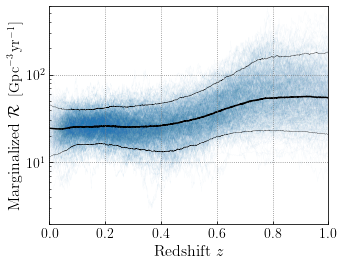

In [7]:
# Plot result as a safety check
fig = plt.figure(figsize=(5,4))
ax = fig.add_subplot(111)
ax.set_rasterization_zorder(2)

# Plot a random subset of our AR posterior
for i in np.random.choice(range(R_zs.shape[1]),size=500,replace=False):                 
    ax.plot(zs,marginal_R_zs[:,i],color='#1f78b4',alpha=0.1,lw=0.1,zorder=0)

# Highlight median and 90% credible intervals
ax.plot(zs,np.median(marginal_R_zs,axis=1),color='black',zorder=1)
ax.plot(zs,np.quantile(marginal_R_zs,0.05,axis=1),color='black',lw=0.3,zorder=1)
ax.plot(zs,np.quantile(marginal_R_zs,0.95,axis=1),color='black',lw=0.3,zorder=1)

# Misc formatting
ax.tick_params(labelsize=14)
ax.set_xlim(0,1.)
ax.set_ylim(2,600)
ax.set_yscale('log')
ax.set_ylabel(r'Marginalized $\mathcal{R}$ \,{\Large[$\mathrm{Gpc}^{-3}\,\mathrm{yr}^{-1}$]}',fontsize=16)
ax.set_xlabel('Redshift $z$',fontsize=16)
plt.show()

In [8]:
# Initial guess of sigmoid parameters
sigmoid_z0 = 0.65
sigmoid_dz = 0.075
sigmoid_r0 = 18
sigmoid_dr = 40

# Initial guess of bpl parameters
bpl_zb = 0.5
bpl_k1 = 0.
bpl_k2 = 8.
bpl_r0 = 18.

# Read out necessary data
# At redshifts above z=0.8 or so, our AR fit begins reverting to the prior, so restrict our fit to z<0.8
zs_to_fit = zs[zs<0.8]
R_z_target = np.median(marginal_R_zs,axis=1)[zs<0.8]

# Least squares loss function under the sigmoid model
def ls_sigmoid(params):
    
    # Read tuple of parameters describing redshift evolution
    z0,dz,r0,dr = params
    R_z_model = sigmoid(zs_to_fit,z0,dz,r0,dr)
    
    # Return squared difference between model prediction and target data
    return np.trapz((np.log(R_z_target)-np.log(R_z_model))**2,zs_to_fit)

# Least squares loss function under broken power law model
def ls_bpl(params):
    
    # Read tuple of parameters describing redshift evolution
    zb,k1,k2,r0 = params
    R_z_model = broken_pl(zs_to_fit,zb,k1,k2,r0)
    
    # Return squared difference between model prediction and target data
    return np.trapz((np.log(R_z_target)-np.log(R_z_model))**2,zs_to_fit)

# Fit!
initial_params_sigmoid = (sigmoid_z0,sigmoid_dz,sigmoid_r0,sigmoid_dr)
marginalized_sigmoid_soln = minimize(ls_sigmoid,initial_params_sigmoid,method='Nelder-Mead',options={'maxiter':1e4})

initial_params_bpl = (bpl_zb,bpl_k1,bpl_k2,bpl_r0)
marginalized_bpl_soln = minimize(ls_bpl,initial_params_bpl,method='Nelder-Mead',options={'maxiter':1e4})

print(marginalized_sigmoid_soln)
print(marginalized_bpl_soln)

 final_simplex: (array([[ 0.64386025,  0.08022852, 25.01140402, 33.9072464 ],
       [ 0.6438607 ,  0.08022853, 25.0114065 , 33.90731986],
       [ 0.64386068,  0.08022857, 25.01141133, 33.90729722],
       [ 0.64385998,  0.08022825, 25.01141363, 33.90718185],
       [ 0.64386027,  0.08022847, 25.01141033, 33.9072624 ]]), array([0.00015241, 0.00015241, 0.00015241, 0.00015241, 0.00015241]))
           fun: 0.00015240856817531234
       message: 'Optimization terminated successfully.'
          nfev: 361
           nit: 220
        status: 0
       success: True
             x: array([ 0.64386025,  0.08022852, 25.01140402, 33.9072464 ])
 final_simplex: (array([[ 0.44217425,  0.21430854,  3.45616764, 26.41273427],
       [ 0.44217473,  0.21432307,  3.45614036, 26.41282681],
       [ 0.44217455,  0.21430449,  3.45617232, 26.41269541],
       [ 0.44217547,  0.21430615,  3.45617147, 26.41276943],
       [ 0.44217678,  0.21431856,  3.45619638, 26.41279348]]), array([0.00023573, 0.00023573, 0.

In [9]:
# Save our fitting results

fitted_sigmoid_z0,fitted_sigmoid_dz,fitted_sigmoid_r0,fitted_sigmoid_dr = marginalized_sigmoid_soln.x
fitted_bpl_zb,fitted_bpl_k1,fitted_bpl_k2,fitted_bpl_r0 = marginalized_bpl_soln.x

with open('./../macros/fitting_results_marginalized_z.txt','w') as macrofile:
    
    macrofile.write("\\newcommand{{\\MarginalRedshiftFitSigmoidZCenter}}{{{0:.2f}}}".format(fitted_sigmoid_z0))
    macrofile.write("\n")
    
    macrofile.write("\\newcommand{{\\MarginalRedshiftFitSigmoidDeltaZ}}{{{0:.2f}}}".format(fitted_sigmoid_dz))
    macrofile.write("\n")
    
    macrofile.write("\\newcommand{{\\MarginalRedshiftFitSigmoidRateLow}}{{{0:.1f}}}".format(fitted_sigmoid_r0))
    macrofile.write("\n")
    
    macrofile.write("\\newcommand{{\\MarginalRedshiftFitSigmoidDeltaRate}}{{{0:.1f}}}".format(fitted_sigmoid_dr))
    macrofile.write("\n")
    
    macrofile.write("\\newcommand{{\\MarginalRedshiftFitBplZBreak}}{{{0:.2f}}}".format(fitted_bpl_zb))
    macrofile.write("\n")
    
    macrofile.write("\\newcommand{{\\MarginalRedshiftFitBplKappaLow}}{{{0:.1f}}}".format(fitted_bpl_k1))
    macrofile.write("\n")
    
    macrofile.write("\\newcommand{{\\MarginalRedshiftFitBplKappaHigh}}{{{0:.1f}}}".format(fitted_bpl_k2))
    macrofile.write("\n")
    
    macrofile.write("\\newcommand{{\\MarginalRedshiftFitBplRateBreak}}{{{0:.1f}}}".format(fitted_bpl_r0))
    macrofile.write("\n")

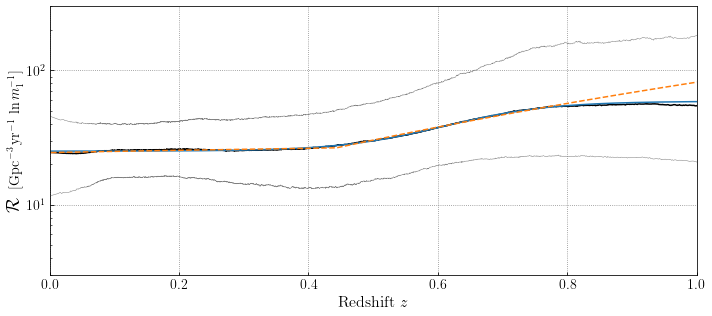

In [10]:
# Finally, plot our fits to double-check that everything is working as intended

# Set up figure
fig = plt.figure(figsize=(10,4.5))
ax = fig.add_subplot(111)
ax.set_rasterization_zorder(2)

# Plot AR model results
ax.plot(zs,np.median(marginal_R_zs,axis=1),color='black',zorder=1)
ax.plot(zs,np.quantile(marginal_R_zs,0.05,axis=1),color='grey',lw=0.5,zorder=1)
ax.plot(zs,np.quantile(marginal_R_zs,0.95,axis=1),color='grey',lw=0.5,zorder=1)

# Plot least-squares sigmoid fit
sigmoid_fit_results = sigmoid(zs,*marginalized_sigmoid_soln.x)
ax.plot(zs,sigmoid_fit_results)

# ...and least-squares BPL fit
bpl_fit_results = broken_pl(zs,*marginalized_bpl_soln.x)
ax.plot(zs,bpl_fit_results,ls='--')

# Misc formatting
ax.tick_params(labelsize=14)
ax.set_xlim(0,1.)
ax.set_ylim(0,100)
ax.set_ylim(3,3e2)
ax.set_yscale('log')
ax.set_ylabel(r'$\mathcal{R}$ \,{\Large[$\mathrm{Gpc}^{-3}\,\mathrm{yr}^{-1}\,\ln m_1^{-1}$]}',fontsize=18)
ax.set_xlabel('Redshift $z$',fontsize=16)

plt.tight_layout()
plt.show()

## 2. Plot AR results alongside LVK parametric fit

In [11]:
# Read out the posterior on the merger R(lnm1,q) as a function of redshift, as measured by the LVK.
lvk_z_grid,lvk_R_z = get_lvk_z(1000,m1_ref=20.)

/Users/tcallister/Documents/Repositories/autoregressive-bbh-inference/figures/read_O3_LVK_results.py:182: RuntimeWarning: overflow encountered in exp
  q_smoothing[to_smooth] = 1./(np.exp(delta_m/((Q*M)[to_smooth]-mMin) + delta_m/((Q*M)[to_smooth]-mMin-delta_m))+1.)
/Users/tcallister/Documents/Repositories/autoregressive-bbh-inference/figures/read_O3_LVK_results.py:186: RuntimeWarning: divide by zero encountered in power
  p_q_unnormed = Q**bq/(1.-(mMin/M)**(1.+bq))*q_smoothing
/Users/tcallister/Documents/Repositories/autoregressive-bbh-inference/figures/read_O3_LVK_results.py:186: RuntimeWarning: invalid value encountered in multiply
  p_q_unnormed = Q**bq/(1.-(mMin/M)**(1.+bq))*q_smoothing
/Users/tcallister/Documents/Repositories/autoregressive-bbh-inference/figures/read_O3_LVK_results.py:192: RuntimeWarning: invalid value encountered in true_divide
  p_q = p_q_unnormed/np.trapz(p_q_unnormed,q_grid,axis=0)
/Users/tcallister/Documents/Repositories/autoregressive-bbh-inference/figures/

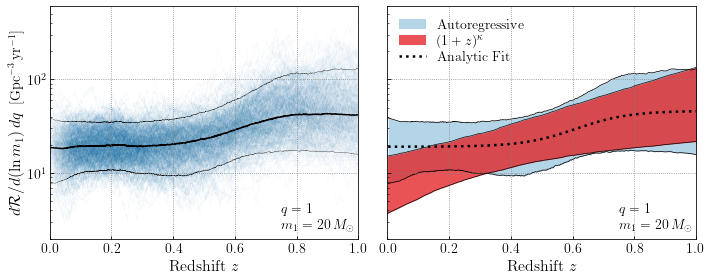

In [12]:
###############################
# Plot AR inference results
###############################

fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(121)
ax.set_rasterization_zorder(2)

# Plot a random subset of our AR posterior
for i in np.random.choice(range(R_zs.shape[1]),size=500,replace=False):                 
    ax.plot(zs,R_zs[:,i],color='#1f78b4',alpha=0.1,lw=0.1,zorder=0)

# Highlight median and 90% credible intervals
ax.plot(zs,np.median(R_zs,axis=1),color='black',zorder=1)
ax.plot(zs,np.quantile(R_zs,0.05,axis=1),color='black',lw=0.3,zorder=1)
ax.plot(zs,np.quantile(R_zs,0.95,axis=1),color='black',lw=0.3,zorder=1)

# Misc formatting
ax.tick_params(labelsize=14)
ax.set_xlim(0,1.)
ax.set_ylim(2,6e2)
ax.set_yscale('log')
ax.text(0.75,0.06,r'$m_1=20\,M_\odot$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=14)
ax.text(0.75,0.13,r'$q=1$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=14)
ax.set_ylabel(r'$d\mathcal{R}/d(\ln m_1)\,dq$ \,{\Large[$\mathrm{Gpc}^{-3}\,\mathrm{yr}^{-1}$]}',fontsize=16)
ax.set_xlabel('Redshift $z$',fontsize=16)

##############################################
# Set up additional figure to plot LVK result
##############################################

ax = fig.add_subplot(122)
ax.set_rasterization_zorder(2)
    
# Plot our AR result
ax.plot(zs[::10],np.quantile(R_zs[::10],0.05,axis=1),color='black',lw=0.75,zorder=1)
ax.plot(zs[::10],np.quantile(R_zs[::10],0.95,axis=1),color='black',lw=0.75,zorder=1)
ax.fill_between(zs[::10],
                np.quantile(R_zs[::10],0.05,axis=1),
                np.quantile(R_zs[::10],0.95,axis=1),
                color='#a6cee3',alpha=0.85,zorder=0,lw=0,
                label='Autoregressive')

# Additionally plot LVK result using power-law model
ax.plot(lvk_z_grid,np.quantile(lvk_R_z,0.05,axis=0),color='black',lw=0.75,alpha=0.9,zorder=3)
ax.plot(lvk_z_grid,np.quantile(lvk_R_z,0.95,axis=0),color='black',lw=0.75,alpha=0.9,zorder=3)
ax.fill_between(lvk_z_grid,
                np.quantile(lvk_R_z,0.05,axis=0),
                np.quantile(lvk_R_z,0.95,axis=0),
                color='#e31a1c',alpha=0.75,zorder=0,lw=0,
                label=r'$(1+z)^\kappa$')

# Plot our least-squares sigmoid fit
sigmoid_fit = sigmoid(zs,*sigmoid_soln.x)
ax.plot(zs,sigmoid_fit,color='black',ls=':',lw=2.5,label='Analytic Fit')

# Misc formatting
ax.tick_params(labelsize=14)
ax.set_xlim(0,1.)
ax.set_ylim(2,6e2)
ax.set_yscale('log')
ax.set_yticklabels([])
ax.legend(loc=(0.02,0.73),fontsize=14,labelspacing=0.2,handlelength=1.9)
ax.text(0.75,0.06,r'$m_1=20\,M_\odot$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=14)
ax.text(0.75,0.13,r'$q=1$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=14)
ax.set_xlabel('Redshift $z$',fontsize=16)

plt.tight_layout()
plt.savefig('figure_06.pdf',bbox_inches='tight',dpi=200)
plt.show()